# U.S. County Mental Health Analysis

This Jupyter Notebook is the result of the collaborative work between Song Ying and Mate Pocs, carried out for Flatiron School's Mod4 Project. 

In [40]:
# importing standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import math
import seaborn as sns

# importing our code we created for the project
import us_county

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from itertools import combinations


## Data

There are two available data files for this project: 
<br>
- 2019 County Health Rankings Data - v2.xls
- analytic_data2019.csv
<br>

The <code>.xls</code> file contains some of the raw data, aggregated statistics calculated from the data, and most importantly, the data dictionary. The <code>.csv</code> file contains more raw data. After comparing the two files, we decided to use the <code>.xls</code> file for getting a better understanding with the data dictionary, and use the <code>.csv</code> file to import the data. 

In [2]:
# importing data from .csv file
df = pd.read_csv('analytic_data2019.csv')

The <code>.csv</code> file has a few columns that identify the county, and then, different aspects of the same variable. We decided that a good way to filter down to the necessary data is to search for "rawvalue"-s. These usually correspond to the bold figures in the Excel file. For a couple of categories, multiple columns are bold in the <code>.xls</code> file, but in those cases, we decided that we can still use the <code>rawvalue</code> columns, the other bold value is the simple the reciprocal of the first one in these cases. 

In [3]:
# keeping first 6 columns and rawvalues
columns_to_drop = []
for column in df.columns[6:]:
    if not (df[column][0]).endswith('rawvalue'):
        columns_to_drop.append(column)
        
df.drop(columns_to_drop, inplace = True, axis = 1)

In [4]:
# dropping first row, which is the second header
df.drop(0, axis = 0, inplace = True)

Next we are dropping the aggregate rows. The per country / per state aggregate rows are coded either as '000' or 0 in the <code>Country FIPS Code</code> column. 

In [5]:
df.shape

(3194, 111)

In [6]:
df = df[df['County FIPS Code'] != '000']

In [7]:
df = df[df['County FIPS Code'] != 0]

In [8]:
df.shape

(3142, 111)

We dropped 52 rows, which sounds correct.
<br>

We are left with 3,142 rows. From the [Wikipedia] page: _"As of 2018, there are currently 3,142 counties and county-equivalents in the 50 states and the District of Columbia."_

[Wikipedia]: https://en.wikipedia.org/wiki/County_(United_States)

Next, we are checking for missing data. There are a lot of columns with over 1,000 missing elements. Interestingly, there are items at the end of the <code>.csv</code> file that are only populated for one state. We are looping through the columns, and dropping the columns where more than 10% of the rows are missing. 

In [9]:
# dropping columns missing more than 10% of the data
columns_to_drop = []
for column in df.columns:
    if df[column].isna().sum() > len(df) / 10:
        columns_to_drop.append(column)
        
df.drop(columns_to_drop, axis = 1, inplace = True)

In [11]:
len(columns_to_drop)

43

In [13]:
columns_to_drop;

In [14]:
# checking for remaining missing data
df_missing_values = pd.DataFrame()

missing_number = []
column_name = []

for column in df.columns:
    column_name.append(column)
    missing_number.append(df[column].isna().sum())
    
df_missing_values['column_name'] = column_name
df_missing_values['missing_number'] = missing_number

In [15]:
df_missing_values = df_missing_values.sort_values('missing_number', ascending = False)

In [16]:
df_missing_values.head(10)

,column_name,missing_number
23,Mental health providers raw value,252
34,Violent crime raw value,191
18,Sexually transmitted infections raw value,158
19,Teen births raw value,144
21,Primary care physicians raw value,135
53,Children eligible for free or reduced price lu...,121
10,Low birthweight raw value,107
35,Injury deaths raw value,103
27,High school graduation raw value,99
22,Dentists raw value,85


There are smaller portions missing from multiple columns. We did not want to exclude these from the analysis, or delete rows where any element was missing. We decided to impute these values with a median method. Before we do that, however, we need to make sure that the values are floats, and we are also renaming the columns to make it easier to worki with them. 

In [17]:
rename_dictionary = us_county.rename_dictionary
df.rename(columns=rename_dictionary, inplace = True);

All columns should be floats. 

In [18]:
for column in df.columns[6:]:
    df[column] = df[column].map(lambda x: float(x))

Next, we create a separate DataFrame with the median values. 

In [19]:
state_median_df = df.groupby('state').median()

In [20]:
state_median_df.head()

,YPLL,poor_health,poor_physical_health_days,poor_mental_health_days,LBW,smokers,obese,food_environment_index,physically_inactive,exercise_acces,...,above_age65,nonhisp_africanamerican,americanindian_alaskannative,asian,nativehawaiian_otherpacific,hispanic,nonhispanic_whit,notproficient_english,females,rural
state,,,,,,,,,,,,,,,,,,,,,
AK,7876.536065,0.154541,3.745194,3.442669,0.058552,0.187008,0.3220,6.90,0.211,0.786260,...,0.125880,0.009324,0.163031,0.024990,0.003460,0.049265,0.498513,0.009650,0.472936,0.793375
AL,10875.865439,0.222160,4.699272,4.740404,0.101167,0.207356,0.3710,7.10,0.309,0.483473,...,0.184502,0.230050,0.005291,0.005651,0.000738,0.026710,0.689275,0.005943,0.514528,0.712322
AR,10744.462101,0.226897,4.893776,4.968565,0.084203,0.207739,0.3580,6.60,0.345,0.532240,...,0.190218,0.081519,0.007149,0.005667,0.000569,0.035295,0.796092,0.005745,0.507171,0.650608
AZ,7833.688943,0.208533,4.509992,4.033836,0.070935,0.156047,0.2970,6.20,0.243,0.666617,...,0.183112,0.012587,0.043069,0.011259,0.001833,0.300955,0.541257,0.038441,0.499798,0.331972
CA,6435.574344,0.163038,3.685637,3.820639,0.064516,0.123397,0.2445,7.85,0.182,0.870061,...,0.153316,0.018185,0.024039,0.044984,0.003119,0.256328,0.518193,0.065316,0.501381,0.160382


In [21]:
overall_median_df = df.median()

In [22]:
overall_median_df.head()

FIPS_state        29.000000
FIPS_county       79.000000
FIPS_full      29176.000000
year            2019.000000
YPLL            8130.554003
dtype: float64

In [23]:
def impute_per_state_median(row, column):
    """
    Checks if a value in a row is missing. 
    If it is missing, first tries to replace it with the median of the values derived from the same state. 
    If all the values are missing for a certain state (for example, Hawaii - water pollution), 
    replaces it with the median of the whole column. 
    
    Parameters
    ----------
    row : current row in the dataframe we want to populate
    
    column: the value that we want to populate
    
    """
    
    if math.isnan(row[column]):
        current_state = row['state']
        current_state_median = state_median_df.loc[current_state][column]
        overall_median = overall_median_df[column]
        if math.isnan(current_state_median):
            return overall_median
        else:
            return current_state_median
    else:
        return row[column]

In [24]:
# code runs for some time
for column in df.columns[6:]:
    df[column] = df.apply(lambda x: impute_per_state_median(x, column), axis = 1)

In [27]:
# checking if we are still missing values
df.isna().sum().sort_values()

FIPS_state                    0
air_pollution                 0
water_violation               0
severe_housing_problems       0
driving_alone_work            0
                             ..
uninsured                     0
teen_birth_rate               0
chlamydia_rate                0
preventable_hospital_stays    0
rural                         0
Length: 68, dtype: int64

As a final step in the data preparation, we are saving the clean data as a .csv file so we can just import it in the future. 

In [28]:
df.to_csv('data_cleaned.csv', index = False)

__Summary__: 
<br>

In this section, we 
- imported the data from <code>analytic_data2019.csv</code>;
- filtered to the data we actually need;
- renamed the columns
- dropped the columns where more than 10% of the data was missing
- filled the remaining missing values with the median based on state (if available), or the country total median;
- finally, saved the cleaned dataset as <code>data_cleaned.csv</code>.

## Initial Data Exploration

In this section, we are using visual aids to explore the data, check if the dependent variable is a good choice, etc. 

In [29]:
df = pd.read_csv('data_cleaned.csv')

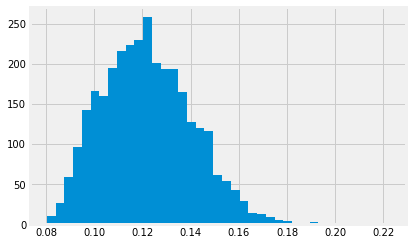

In [30]:
plt.hist(df['frequent_mental_distress'], bins = 'auto')
plt.show()

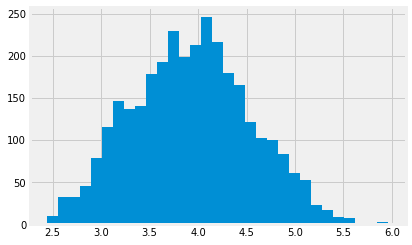

In [31]:
plt.hist(df['poor_mental_health_days'], bins = 'auto')
plt.show()

The two variables look similar and seem to be highly correlated. The question is, do we want to analyse the overall mental health (<code>poor_mental_health_days</code>), or the percentage of people in extremely poor mental health in thepopulation (<code>frequent_mental_distress</code>). 
<br>

We decided to use <code>poor_mental_health_days</code> variable, so our focus is on the average mental health of the population. 
<br>

In the following, we are exploring a few randomly picked variables to get a preliminary picture. 

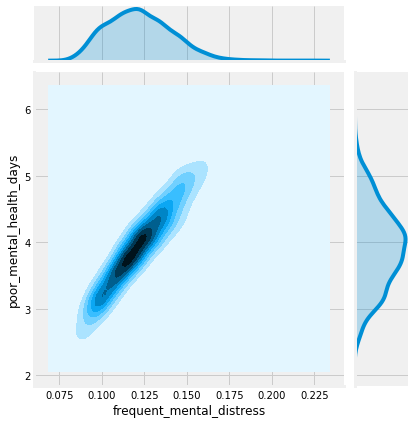

In [33]:
sns.jointplot("frequent_mental_distress", "poor_mental_health_days", data=df, kind='kde')
plt.show()

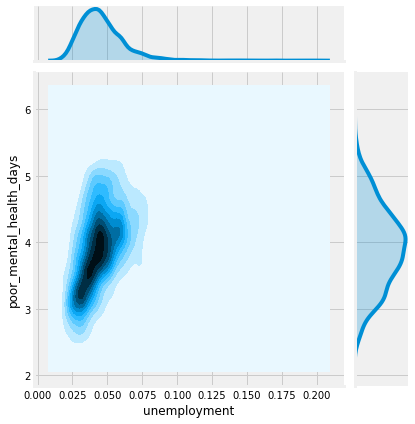

In [35]:
sns.jointplot("unemployment", "poor_mental_health_days", data=df, kind='kde')
plt.show()

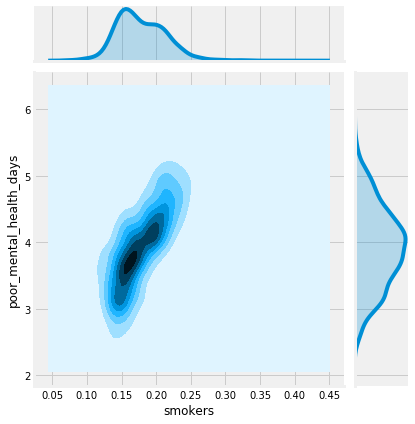

In [36]:
sns.jointplot("smokers", "poor_mental_health_days", data=df, kind='kde')
plt.show()

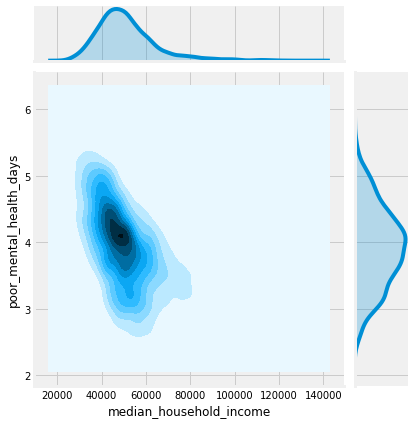

In [37]:
sns.jointplot("median_household_income", "poor_mental_health_days", data=df, kind='kde')
plt.show()

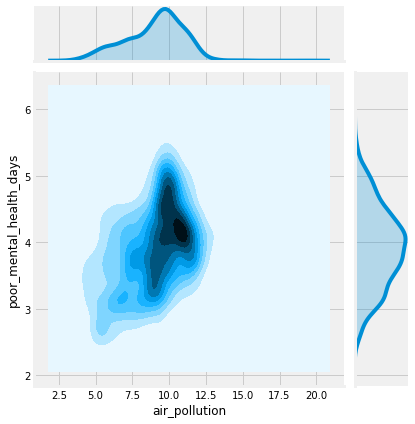

In [38]:
sns.jointplot("air_pollution", "poor_mental_health_days", data=df, kind='kde')
plt.show()

__Summary__: 
<br>

In this section, we did a preliminary check on the dependent variable. We picked <code>poor_mental_health_days</code> seems like a good candidate for linear regression analysis. 

## Linear Regression - Data Preparation

In [39]:
df = pd.read_csv('data_cleaned.csv')

### Excluding Trivial Variables

A lot of health-related values are highly correlated with each other. While keeping these variables in the model would result in an accurate model, it would also be a redundant one. In this section, we are checking the correlation with the <code>poor_mental_health_days</code>, and exclude the ones that are 
- highly correlated with it
- based on external information closely related to our target variable

In [41]:
df_for_corr = df.iloc[:,6:]
df_for_corr = df_for_corr.corr()

In [42]:
# checking positive variables first
df_for_corr['poor_mental_health_days'].sort_values(ascending = False).head(10)

poor_mental_health_days             1.000000
frequent_mental_distress            0.953254
poor_physical_health_days           0.919823
frequent_physical_distress          0.878407
poor_health                         0.743129
smokers                             0.739957
insufficient_sleep                  0.691513
diabetes                            0.655154
premature_age_adjusted_mortality    0.647103
children_in_poverty                 0.638065
Name: poor_mental_health_days, dtype: float64

In [43]:
columns_to_exclude_trivial = []
columns_to_exclude_trivial.extend(
    ['frequent_mental_distress', 'poor_physical_health_days', 'frequent_physical_distress', 'poor_health'] 
)

In [44]:
df_for_corr['poor_mental_health_days'].sort_values(ascending = True).head(10)

life_expectancy           -0.633379
excessive_drinking        -0.620358
median_household_income   -0.559596
college                   -0.546793
food_environment_index    -0.403171
mammography_screenings    -0.342726
social_associations       -0.330864
exercise_acces            -0.215343
asian                     -0.197639
uninsured_children        -0.183329
Name: poor_mental_health_days, dtype: float64

In [45]:
columns_to_exclude_trivial.extend(
    ['life_expectancy'] 
)

In [46]:
df.drop(labels = columns_to_exclude_trivial, axis = 1, inplace = True)
df.shape

(3142, 63)

### Checking for Multicollinearity

In [47]:
X = df.drop(['FIPS_state', 'FIPS_county', 'FIPS_full', 'state', 'county', 'year',
    'poor_mental_health_days'], axis = 1)

We are calculating the VIF score of the variables, collecting the ones that would produce a higher score than 10. The scaling does not matter now, should be the same after a linear transformation. 

In [48]:
# the code will run for a while, and print out the name of the column it just dropped

vif_threshold = 10

columns_to_drop_vif = []
highest_vif_too_high = True

while highest_vif_too_high:
    vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif_list = list(zip(X.columns, vif))
    vif_list = sorted(vif_list, key= lambda x: x[1], reverse = True)
    if vif_list[0][1] > vif_threshold:
        current_column_to_drop = vif_list[0][0]
        print(current_column_to_drop)
        columns_to_drop_vif.append(current_column_to_drop)
        X.drop(current_column_to_drop, axis = 1, inplace = True)
    else:
        highest_vif_too_high = False

uninsured
nonhispanic_whit
females
food_environment_index
premature_age_adjusted_mortality
insufficient_sleep
homeownership
driving_alone_work
high_school_graduation
obese
smokers
diabetes
below_age18
income_inequality
median_household_income
physically_inactive
college
food_insecurity
mammography_screenings
severe_housing_problems
LBW
YPLL
excessive_drinking
above_age65
children_in_poverty
air_pollution
children_in_singleparent_household
uninsured_adults
children_elig_lunch
injury_deaths
flu_vaccinated
severe_housing_cost_burden
exercise_acces
teen_birth_rate
unemployment


We do not want to lose all this information, we are going to risk having high multicollinearity for now, if it improves model performance. We want to retain variables that highly correlate with <code>poor_mental_health_days</code>, even if they result in high multicollinearity. 

In [50]:
correl_test_df = pd.DataFrame()
correl_test_df['column_name'] = columns_to_drop_vif

correl_list = []

for column in columns_to_drop_vif:
    current_correl = df['poor_mental_health_days'].corr(df[column])
    correl_list.append(current_correl)
        
correl_test_df['correlation_with_pmhd'] = correl_list

correl_test_df.sort_values('correlation_with_pmhd', ascending = False)

,column_name,correlation_with_pmhd
10,smokers,0.739957
5,insufficient_sleep,0.691513
11,diabetes,0.655154
4,premature_age_adjusted_mortality,0.647103
24,children_in_poverty,0.638065
17,food_insecurity,0.608685
21,YPLL,0.591831
15,physically_inactive,0.517016
26,children_in_singleparent_household,0.497505
33,teen_birth_rate,0.495828


The table above contains variables which have a high amount of multicollinearity, ordered by their correlation with the target variable. We are dropping everything from the dataframe that correlates with less than 0.5 in absolute value. 

In [51]:
columns_to_drop_vif_corr = correl_test_df[np.abs(correl_test_df['correlation_with_pmhd']) < 0.5]['column_name']
columns_to_drop_vif_corr = columns_to_drop_vif_corr.tolist()
df.drop(labels = columns_to_drop_vif_corr, axis = 1, inplace = True)
df.shape

(3142, 39)

We are re-checking the remaining columns for multicollinearity using the VIF scores. 

In [52]:
X = df.drop(['FIPS_state', 'FIPS_county', 'FIPS_full', 'state', 'county', 'year',
    'poor_mental_health_days'], axis = 1)

vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_list = list(zip(X.columns, vif))
vif_list = sorted(vif_list, key= lambda x: x[1], reverse = True)

vif_list[:10]

[('premature_age_adjusted_mortality', 233.25558219740464),
 ('insufficient_sleep', 217.44478465512395),
 ('YPLL', 142.864504054577),
 ('smokers', 113.91935364696032),
 ('diabetes', 86.14532969642397),
 ('physically_inactive', 82.62067354332544),
 ('median_household_income', 67.47821486341186),
 ('college', 60.47365117392558),
 ('excessive_drinking', 55.6495204756171),
 ('food_insecurity', 51.4107881277985)]

__Summary__: 
<br>

We decided to follow this process: 
<br>

- Create a list of variables we would exclude based on VIF
- Calculate the correlation with the dependenta variable, and keep the variables which correlate by more than 0.5 (in absolute value), and exclude the rest
- This way, we exclude a number of variables which do not highly correlate with the base value but produce multicollinearity in the model
- We decided to suffer the consequences of keeping the rest. 

### Checking Linearity

In this section, we check if there is any visible non-linear relationship between the variables, to see if we need to use a log- or sqrt-scale. 

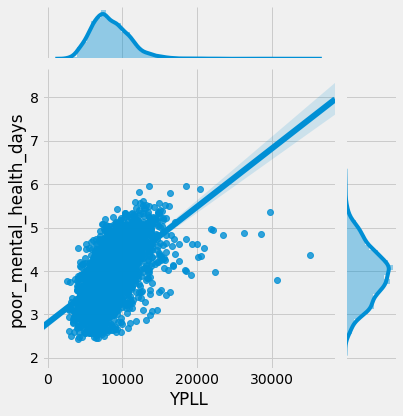

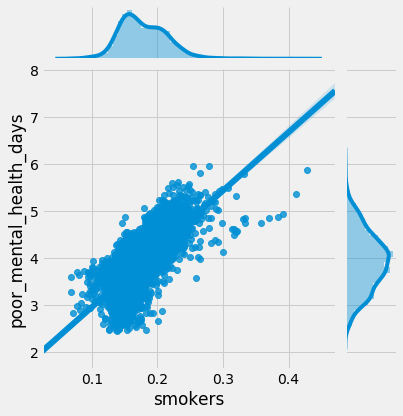

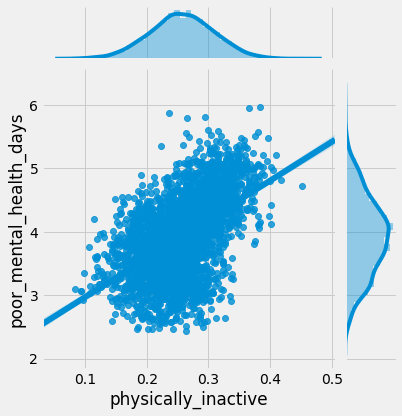

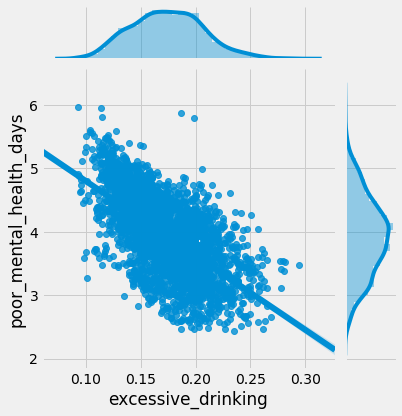

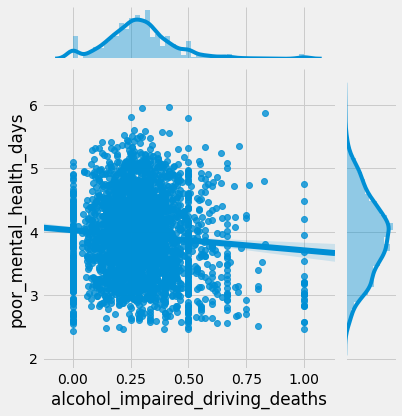

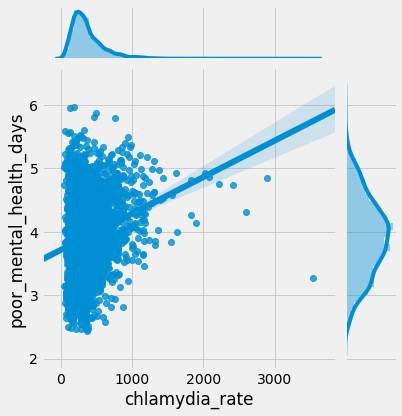

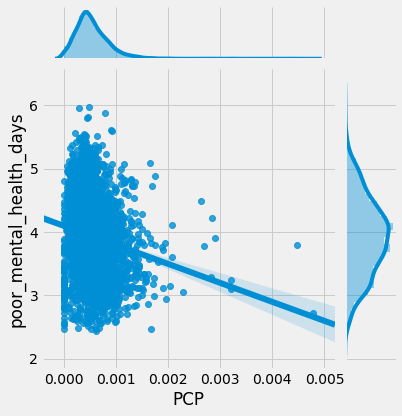

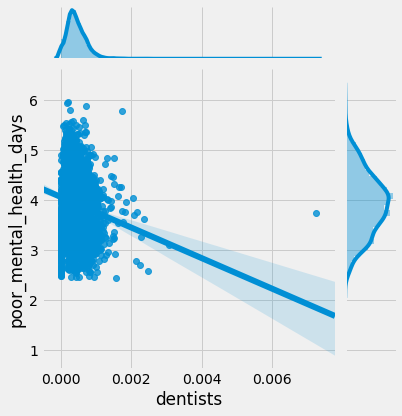

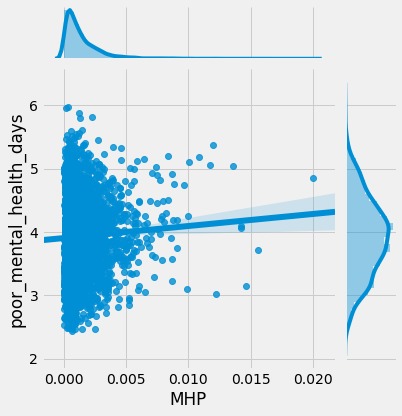

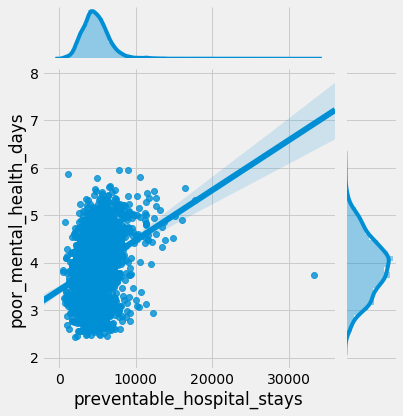

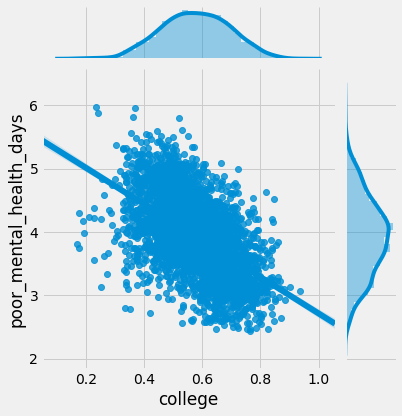

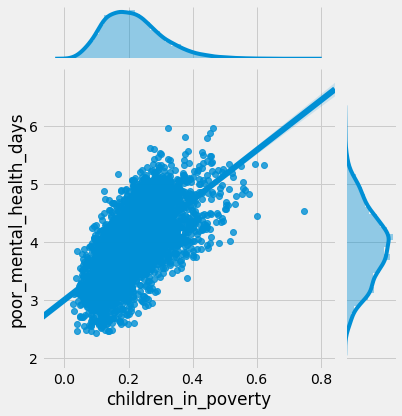

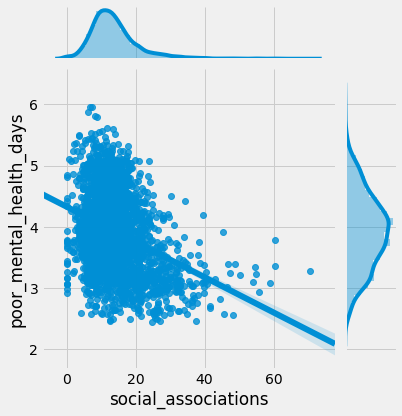

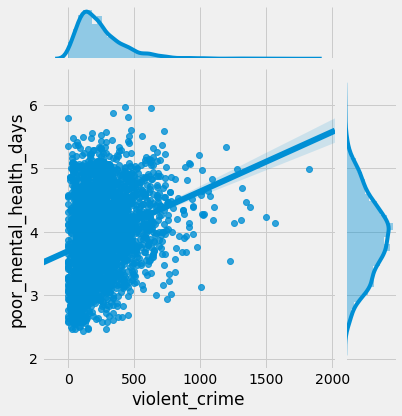

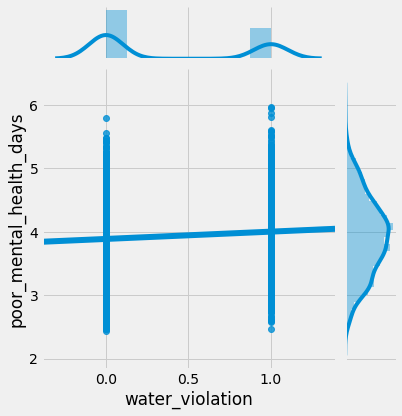

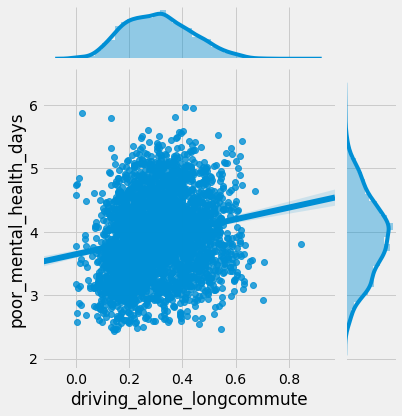

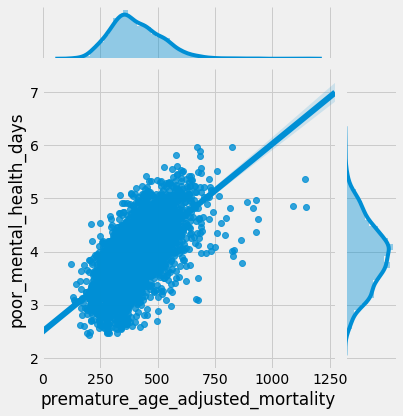

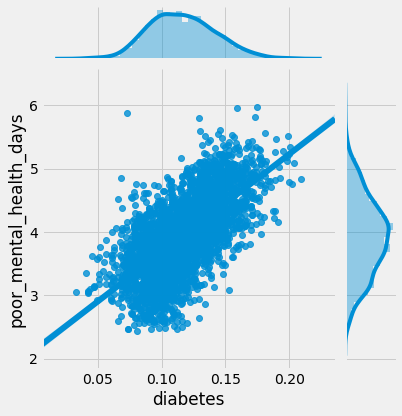

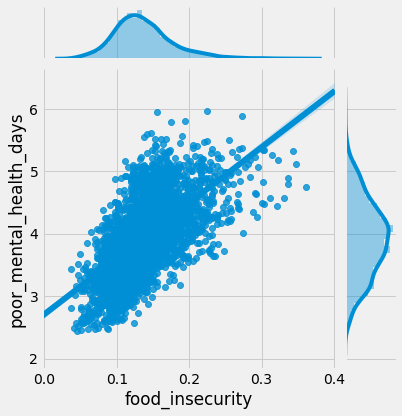

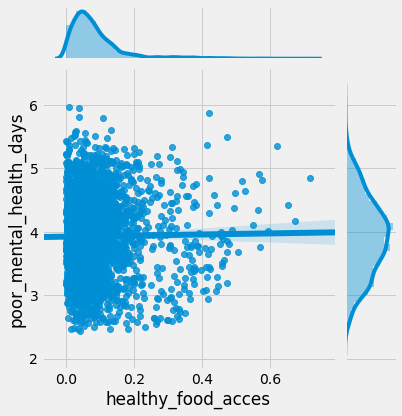

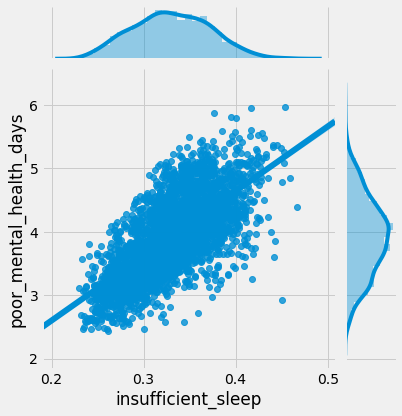

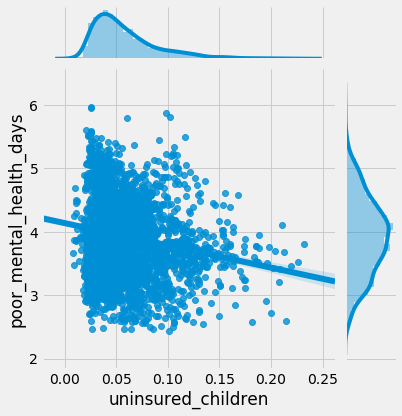

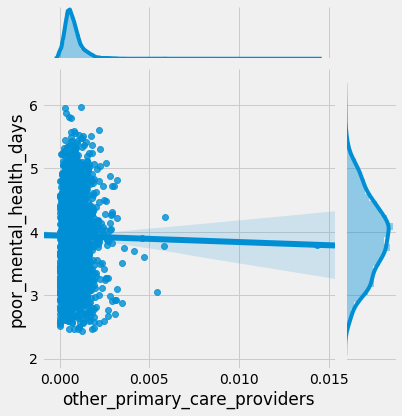

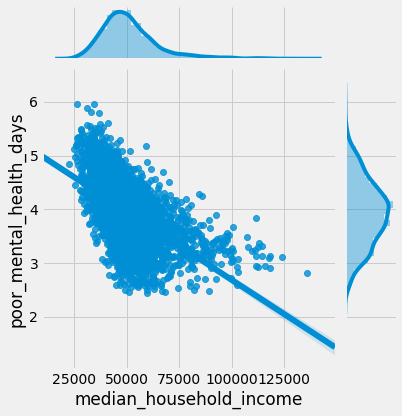

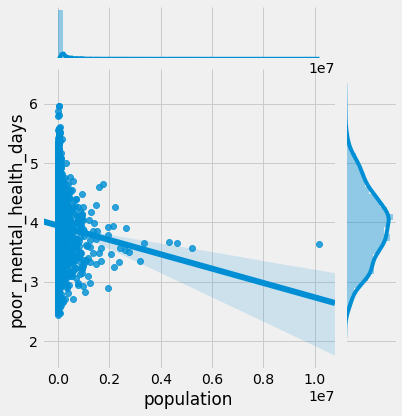

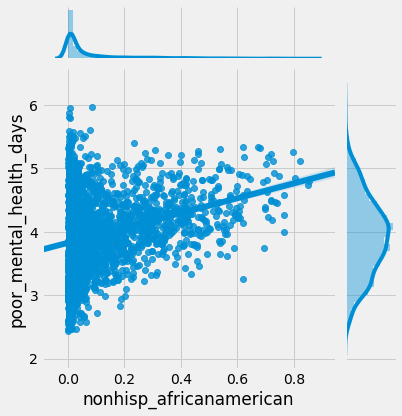

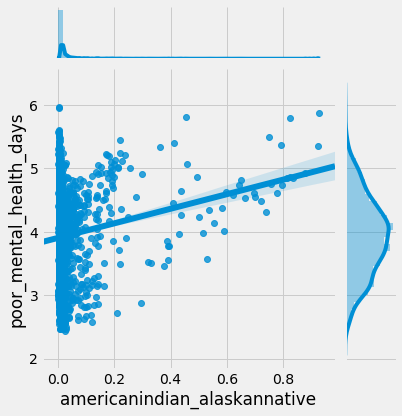

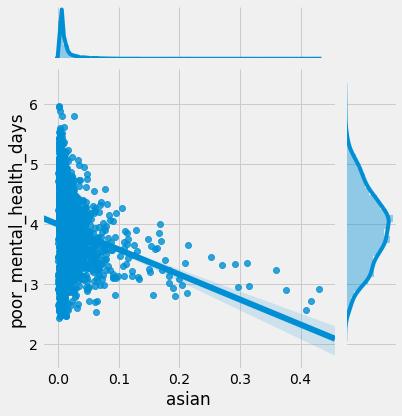

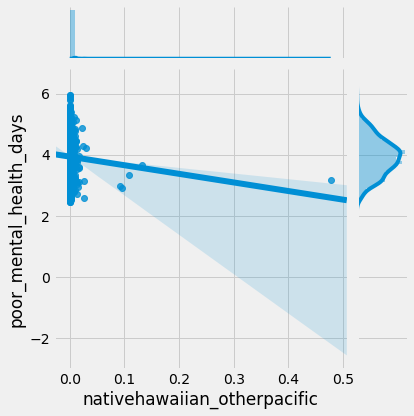

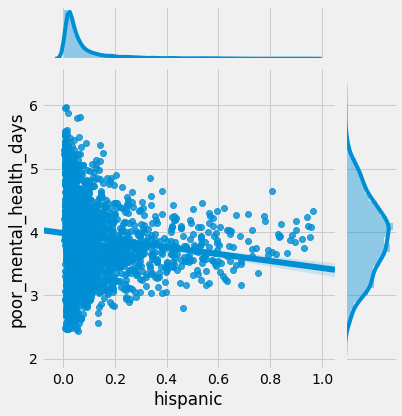

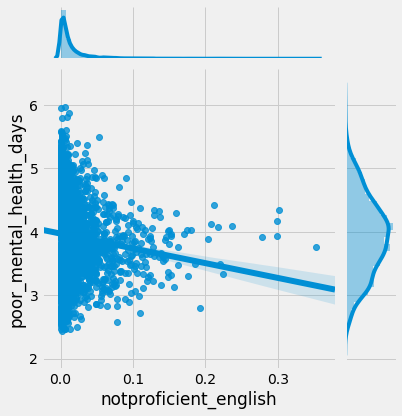

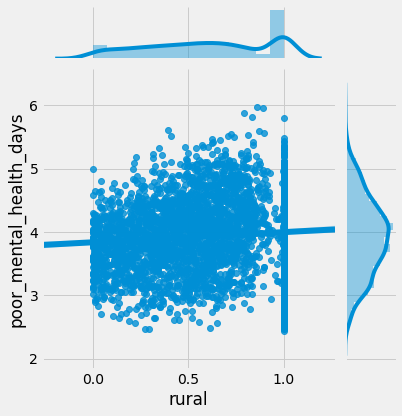

In [53]:
for column in X.columns: 
    sns.jointplot(column, 'poor_mental_health_days', data=df, kind='reg')
    plt.show()

__Summary__: 
<br>

We decided not to apply a log- or sqrt-transformation on the data. There was no apparent non-linear connection. An alternative method would be to include these adjusted columns for each column.  

### Data Preparation Summary

As a final step, we save the current df again as a .csv, so in the linear regression modeling part, we can just start by importing it. 

In [54]:
df.to_csv('data_linreg.csv', index = False)

__Summary__: 
<br>

In the data preparation section, we 
- excluded the variables which were too close to the target
- excluded variables based on multicollinearity
- checked if we need to adjust any of the variables due to obvious non-linear relationships with the target variable, but decided that we do not need to

## Linear Regression - Baseline and Additional Variables

In [58]:
# importing data from .csv file
df = pd.read_csv('data_linreg.csv')

### Splitting into Test and Train Sets

In [60]:
y = df['poor_mental_health_days']
X = df.drop(['FIPS_state', 'FIPS_county', 'FIPS_full', 'state', 'county', 'year',
    'poor_mental_health_days'], axis = 1)

In [61]:
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

We created the train and test split now, from this point on, we will work with the train set up until the very end of the project. 

### Baseline Model

In this section, we are creating a baseline model, using all our existing variables. This is what we will try to improve later on with additional variables. 

In [62]:
# these are variables we will use for the rest of the project
regression = LinearRegression()
crossvalidation = KFold(n_splits=5, shuffle=True, random_state= 42)

In [64]:
baseline = np.mean(cross_val_score(regression, X_train, y_train, scoring='r2', cv=crossvalidation))
baseline

0.809419744154102

In [65]:
cross_val_score(regression, X_train, y_train, scoring='r2', cv=crossvalidation)

array([0.80948461, 0.82242422, 0.80753549, 0.79593041, 0.81172399])

Using the K-Fold method, we check the model's performance on the different validation sets. The result seems to oscillate around 0.81. 

### Adding Interactions

First, we wanted to analyze the interactions between pairs of variables. 

In [66]:
combs = list(combinations(X_train.columns, 2))

In [67]:
# the cell runs for a while
interactions = []

for comb in combs:
    
    data = X_train.copy()
    
    data['interaction'] = data[comb[0]] * data[comb[1]]
    score = np.mean(cross_val_score(regression, data, y_train, scoring='r2', cv=crossvalidation))
    if score > baseline: interactions.append((comb[0], comb[1], round(score, 3)))

We decided to add the top 10 interaction pairs and see how they improve the model. 

In [68]:
interactions = sorted(interactions, key = lambda x: x[2], reverse = True)
interactions_to_add = [interaction for interaction in interactions[:10]]
interactions_to_add

[('physically_inactive', 'excessive_drinking', 0.817),
 ('uninsured_children', 'nonhisp_africanamerican', 0.816),
 ('physically_inactive', 'premature_age_adjusted_mortality', 0.815),
 ('physically_inactive', 'diabetes', 0.815),
 ('physically_inactive', 'college', 0.814),
 ('children_in_poverty', 'social_associations', 0.814),
 ('population', 'rural', 0.814),
 ('YPLL', 'physically_inactive', 0.813),
 ('physically_inactive', 'americanindian_alaskannative', 0.813),
 ('excessive_drinking', 'rural', 0.813)]

It seems like <code>physically_inactive</code> appears in many combinations, so we are doing further analysis via visualisation. We are going to create a category variable that is determined based on the 33rd and 67th percentile, and then plot linear regressions for the three separate groups. 

In [70]:
physical_inactivity = np.asarray(X_train[['physically_inactive']]).reshape(len(X_train[['physically_inactive']]))

In [71]:
phys_inactivity_category = []
for inactive in X_train.physically_inactive:
    if inactive > np.percentile(physical_inactivity, 67):
        phys_inactivity_category.append('high_inactivity')
    elif inactive > np.percentile(physical_inactivity, 33) and inactive <= np.percentile(physical_inactivity, 67):
        phys_inactivity_category.append('med_inactivity')
    elif inactive <= np.percentile(physical_inactivity, 67):
        phys_inactivity_category.append('low_inactivity')                                
        
X_train['physical_inactivity_cat'] = phys_inactivity_category

In [72]:
data = pd.concat([X_train, y_train], axis =1)
X_train_high_pi = data[data['physical_inactivity_cat'] == 'high_inactivity']
X_train_medium_pi = data[data['physical_inactivity_cat'] == 'med_inactivity']
X_train_low_pi = data[data['physical_inactivity_cat'] == 'low_inactivity']

In [73]:
def plot_with_physical_inactivity(column_name):
    plt.figure(figsize = (10,10))
    sns.regplot(x = X_train_high_pi[column_name], y = X_train_high_pi['poor_mental_health_days'], label='high physical inactivity')
    sns.regplot(x = X_train_medium_pi[column_name], y = X_train_medium_pi['poor_mental_health_days'], label='medium physical inactivity')
    sns.regplot(x = X_train_low_pi[column_name], y = X_train_low_pi['poor_mental_health_days'], label='low physical inactivity')
    plt.legend()
    plt.show()

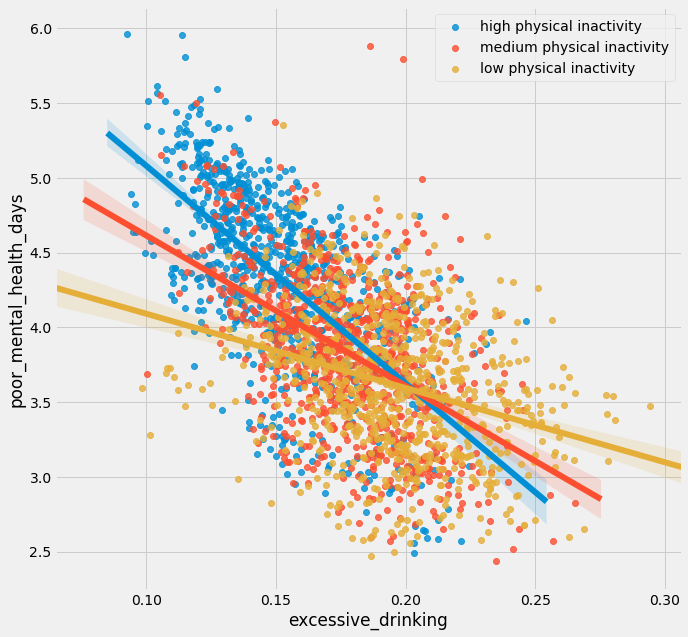

In [74]:
plot_with_physical_inactivity('excessive_drinking')

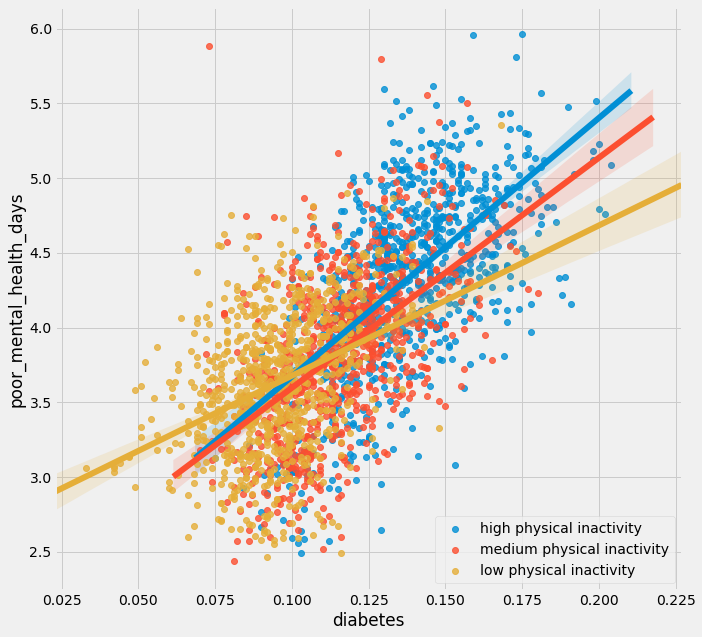

In [75]:
plot_with_physical_inactivity('diabetes')

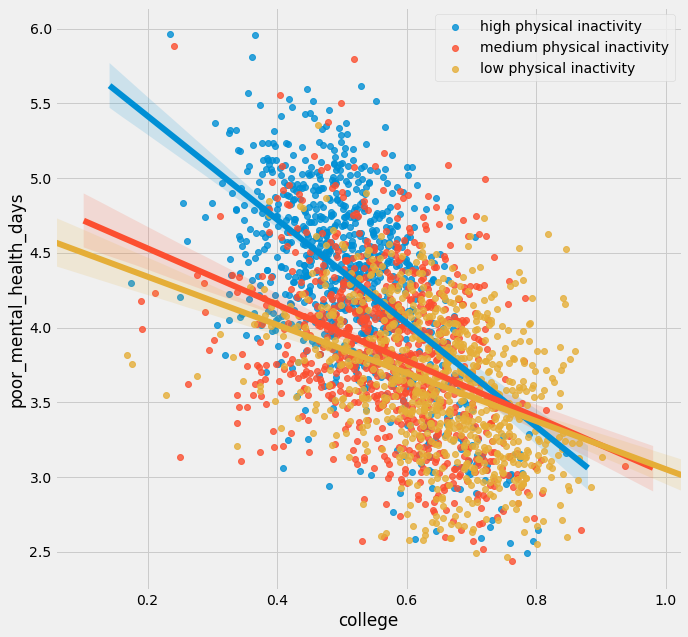

In [76]:
plot_with_physical_inactivity('college')

In [77]:
# dropping the categorical variables after the analysis is done
X_train.drop('physical_inactivity_cat', axis = 1, inplace = True)

Finally, we are checking how much increase we can achieve in the model's performance by adding the top 10 interactions. 

In [78]:
X_train_inter = X_train.copy()
for interaction in interactions_to_add:
    X_train_inter[interaction[0] + '_' + interaction[1]] = \
    X_train_inter[interaction[0]] * X_train_inter[interaction[1]]

In [79]:
interaction_score = np.mean(cross_val_score(regression, X_train_inter, y_train, scoring='r2', cv=crossvalidation))
interaction_score

0.835945599874775

__Summary__: 
<br>

In this section, we examined how the model's performance changes if we add interactions. After analysing the increase on R<sup>2</sup> of adding all the possible combinations individually, we observed one variable, <code>physically_inactive</code> to be relevant in combination of many different variables, so we did some visualisations on that. 
<br>

After that, we added the top 10 interactions (ranked by individual impact on R<sup>2</sup>. This increased the R<sup>2</sup> with about 2.5%.
<br>

### Adding Polynomials

In this section, we are adding the polynomial combinations of the variables, and similarly to the previous section, we check if they improve model performance. 